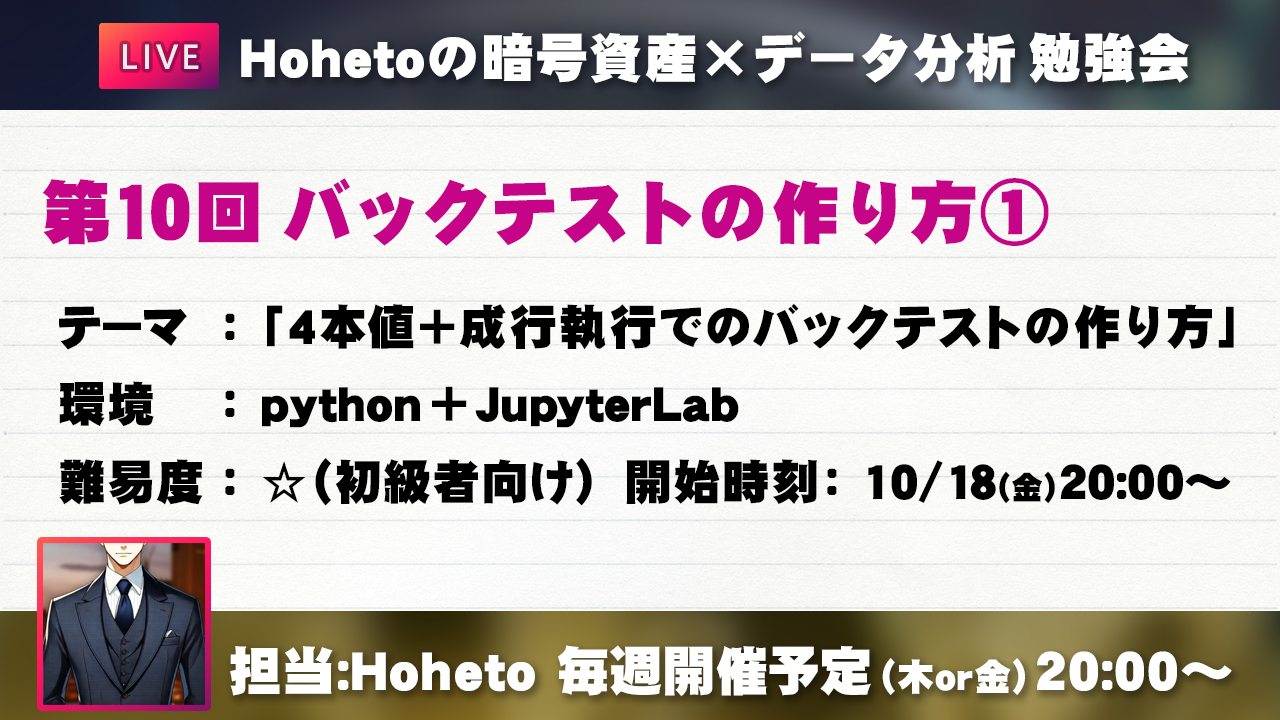

In [1]:
from IPython.display import Image

Image('./images/10_00.png')

# Hoheto勉強会 第10回 バックテストの作り方①

## 免責事項

- この勉強会では、過去のデータ分析を中心に行います。未来の値動きを断定したり投資に関するアドバイスを提供するものではありません。
- 投資は自己責任です。この内容に基づいて視聴者様が行う投資判断やその結果について、配信者は一切の責任を負いません。
- 内容には細心の注意を払っておりますが、正確性を完全に保証するものではありません。

## 概要

- 構築した戦略をもとにバックテストを実装します。
- 今回は4本値（ローソク足）を使って、成行執行する場合のバックテストを実装します。

## 前提知識

- Python。pandas、numpyなどのライブラリ。
- Jupyter。

## 内容・難易度

- 難易度☆ 1つ。

# 環境設定

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import ccxt
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings
from datetime import datetime
from dateutil import parser
from tqdm import tqdm
from IPython.display import display, HTML, Image

In [4]:
# warning表示off
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 7

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (4, 4)

# データ取得

- 前回と同じく、ビットコイン現物および先物の日足データ。
- BitMEX、Binance、bybit、Coinbaseの4つの取引所。

In [5]:
apis = {
    'bitmex': ccxt.bitmex(),
    'binance': ccxt.binanceusdm(),
    'bybit': ccxt.bybit(),
    'coinbase': ccxt.coinbase(),
}

- 取得用関数。

In [6]:
def fetch_ohlcv(exchange, symbol, from_date, to_date, timeframe):
    from_time = int(parser.parse(from_date).timestamp() * 1000)
    to_time = int(parser.parse(to_date).timestamp() * 1000)
    start_time = from_time
    limit = 1000
    ohlcv_list = []
    while True:
        api = apis[exchange]
        ohlcv = api.fetch_ohlcv(symbol=symbol, timeframe=timeframe, since=start_time, limit=limit)
        if len(ohlcv) == 0:
            break
        ohlcv_list += ohlcv
        start_time = ohlcv[-1][0] + 1
        if start_time > to_time:
            break
        time.sleep(1)
    df = pd.DataFrame(ohlcv_list)
    df.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
    df['timestamp'] = pd.to_datetime(df['timestamp'] / 1000, unit='s', utc=True)
    df = df.set_index('timestamp').sort_index()
    df = df[from_date:to_date]
    df['ror'] = (df['close'] - df['open']) / df['open']
    df.columns = [f'{exchange}_{column}' for column in df.columns]
    return df

In [7]:
def plot_corr(series1, series2, title='', xlabel='', ylabel=''):
    corr = series1.corr(series2)
    plt.title(f'{title} (corr={corr:.3f})')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.scatter(series1, series2, alpha=0.5, s=8, label=f'{corr:.3f}')
    plt.legend()

# 前回採用することにした「ベースストラテジー」

- 取引所間乖離を使った戦略。
  - 4種類の日足の終値の乖離を合算する。
    - Bitmex-Binance
    - Bitmex-bybit
    - Coinbase-Binance
    - Coinbase-bybit
  - 合算した乖離指標に対し、
    - プラスならロングポジション、マイナスならショートポジションを作る。
    - 乖離指標の絶対値が0.05%以上であればMAXポジション、それ未満であれば1/2のポジションを作る。
- 詳細は以下の回を参照。
  - 第7回勉強会「取引所間の価格乖離の分析①」
  - 第9回勉強会「暗号資産 運用シミュレーション①」

- OHLCV取得

In [8]:
from_date = '2021-01-01'
to_date = '2024-10-18'

In [9]:
ohlcv = {}

In [10]:
ohlcv['bitmex'] = fetch_ohlcv('bitmex', 'XBTUSD', from_date, to_date, '1d')
ohlcv['bitmex']['bitmex_volume'] = ohlcv['bitmex']['bitmex_volume'] / ohlcv['bitmex']['bitmex_close']

In [11]:
ohlcv['coinbase'] = fetch_ohlcv('coinbase', 'BTC/USD', from_date, to_date, '1d')

In [12]:
ohlcv['binance'] = fetch_ohlcv('binance', 'BTC/USDT:USDT', from_date, to_date, '1d')

In [13]:
ohlcv['bybit'] = fetch_ohlcv('bybit', 'BTC/USDT:USDT', from_date, to_date, '1d')

In [14]:
ohlcv['binance']

,binance_open,binance_high,binance_low,binance_close,binance_volume,binance_ror
timestamp,,,,,,
2021-01-01 00:00:00+00:00,28948.19,29668.86,28627.12,29337.16,210716.398,0.013437
2021-01-02 00:00:00+00:00,29337.15,33480.00,28958.24,32199.91,545541.080,0.097581
2021-01-03 00:00:00+00:00,32198.41,34832.25,32000.02,33054.53,487486.989,0.026589
2021-01-04 00:00:00+00:00,33053.93,33653.56,27800.00,32031.07,506128.023,-0.030945
2021-01-05 00:00:00+00:00,32029.55,34500.00,29900.00,33999.52,433720.833,0.061505
...,...,...,...,...,...,...
2024-10-14 00:00:00+00:00,62839.70,66533.00,62420.00,66064.90,338251.601,0.051324
2024-10-15 00:00:00+00:00,66064.90,67953.70,64771.70,67044.10,422005.511,0.014822
2024-10-16 00:00:00+00:00,67044.00,68400.00,66724.20,67592.00,254153.501,0.008174


- 手数料＋コスト
  - ポジションを1単位作る際のコストを10bpに想定。
    - テイカー手数料 5bp（Binance USDMの場合。bybit無期限はテイカー手数料5.5bp）
    - スリッページ 5bp

In [15]:
fee = 0.001  # 10bp

In [16]:
strategy = ohlcv['binance'].copy()
strategy['ror'] = (strategy['binance_close'] - strategy['binance_open']) / strategy['binance_open']
strategy['bitmex_close'] = ohlcv['bitmex']['bitmex_close']
strategy['coinbase_close'] = ohlcv['coinbase']['coinbase_close']
strategy['bybit_close'] = ohlcv['bybit']['bybit_close']
strategy['bitmex_binance_dev'] = strategy['bitmex_close'] / strategy['binance_close'] - 1
strategy['bitmex_bybit_dev'] = strategy['bitmex_close'] / strategy['bybit_close'] - 1
strategy['coinbase_binance_dev'] = strategy['coinbase_close'] / strategy['binance_close'] - 1
strategy['coinbase_bybit_dev'] = strategy['coinbase_close'] / strategy['bybit_close'] - 1

- 指標が大きいときにポジションを大きく、小さいときはポジションを小さくする。

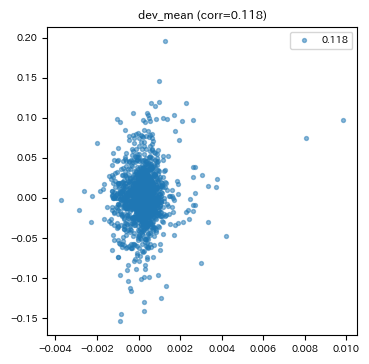

In [17]:
strategy['dev_mean'] = (strategy['bitmex_binance_dev'] + strategy['bitmex_bybit_dev'] + strategy['coinbase_binance_dev'] + strategy['coinbase_bybit_dev']).shift(1) / 4
plot_corr(strategy['dev_mean'], strategy['ror'], title='dev_mean');

- シグナル作成。

In [18]:
strategy['signal'] = 0
strategy.loc[(strategy['dev_mean'] < 0.000), 'signal'] = -0.5
strategy.loc[(strategy['dev_mean'] < -0.0005), 'signal'] = -1.0
strategy.loc[(strategy['dev_mean'] > 0.000), 'signal'] = 0.5
strategy.loc[(strategy['dev_mean'] > 0.0005), 'signal'] = 1.0
print(strategy['signal'].value_counts())
strategy['fee'] = np.abs(strategy['signal'].diff()) * fee
strategy['pnl'] = strategy['signal'] * strategy['ror']
strategy['pnl_with_fee'] = strategy['pnl'] - strategy['fee']
strategy['dd'] = strategy['pnl'].cumsum().cummax() - strategy['pnl'].cumsum()

signal
 0.5    546
 1.0    381
-0.5    267
-1.0    192
 0.0      1
Name: count, dtype: int64


- 結果をプロット。
  - まずまず良好な結果を得られた。

SR(daily): 0.07870
SR(yearly): 1.50354
最大DD: 0.44448


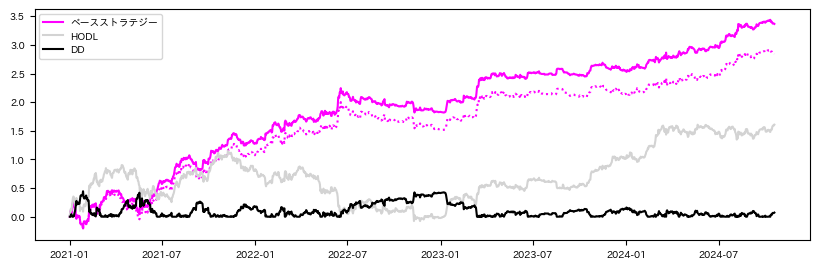

In [19]:
plt.figure(figsize=(10, 3))
plt.plot(strategy['pnl'].cumsum(), label='ベースストラテジー', color='magenta')
plt.plot(strategy['pnl_with_fee'].cumsum(), color='magenta', linestyle=':')
plt.plot(strategy['ror'].cumsum(), label='HODL', color='lightgray')
plt.plot(strategy['dd'], label='DD', color='k')
plt.legend();
sr_daily = strategy["pnl_with_fee"].mean()/strategy["pnl_with_fee"].std()
sr_anual = sr_daily * np.sqrt(365)
print(f'SR(daily): {sr_daily:.5f}')
print(f'SR(yearly): {sr_anual:.5f}')
print(f'最大DD: {strategy["dd"].max():.5f}')

- ここまでは「累積リターン」の確認であった。
- 初期証拠金とレバレッジを設定した「バックテスト」を行う。

# バックテスト（成行執行バージョン）

- バックテスト実装のポイント
  - 執行方法として、成行（テイカー）、指値（メイカー）がある。
  - 戦略によっては、これらを組み合わせる場合がある。この場合、バックテストも複雑になる。

- テイカーの場合
  - 約定する/しないの判定をしなくてよいので、実装が楽。
  - コストが読みづらい。シミュレーションと実運用で以下の違いが起こる。
    - スプレッド。
      - 終値ではbuy側の約定かsell側の約定かを判定できない。このためスプレッドを考慮できない。
    - 板の状況。
      - 直近で約定した価格から板がずれた場合、このずれを把握できない。
    - スリッページ。
      - 板の厚みが分からないため、スリッページの程度を把握できない。
      - 発注サイズが大きくなるとスリッページが大きくなる。
    - 注文の遅れ。
      - 日をまたいでから発注が通るまで、以下のラグがある。
        - 日足が確定するまでにかかる時間（数秒かかる取引所が多い）。
        - データ取得、データ加工、推論などに必要な時間。
        - 発注～注文が通って約定するまでの時間。
      - これにより、スプレッドやスリッページが極小であったとしてもシミュレーションとずれが生じる。
  - 今回のような長い時間足での戦略の場合、
    - 上記全てをざっくりとまとめて5bpとしている（BTCUSDTが流動性が高いことを考慮しても楽観的な数字である。多めに見積もるなら10～15bp程度が妥当か）
    - きちんとやるなら板・約定履歴をつぶさに分析してよりよい執行をできるようにする（別の機会で取り上げるかも）
    - 今回は、シミュレーションと実運用と比較しながらこの見積もりが大幅にずれていないか、を確認する。

- メイカーの場合
  - 時間足のHigh, Lowを見ながら、指値を出した水準を突き抜けているかを確認して、約定した・していないの判定を行う。バックテストが若干複雑になる。
  - コストが基本的にメイカー手数料だけであるため、シミュレーションし易い。
  - 「約定した」と判定しても実運用では約定しないケースがある。
    - 発注までのタイムラグ。
    - フォワード運用の場合、次項のような「自分の注文がなかったらこの価格帯で約定していたはず」というケースが起こり得る。
  - 実運用で大きな板を出すと、それを背にトレードされたり、部分約定が起こるようになる。
    - あまり大きな板を出しすぎると、フォワード運用でシミュレーション・実運用ともに劣化することもありうる。この場合、シミュレーションとの乖離による劣化を観測できないため、厄介である。
    - この「部分約定の割合」を観察することで、キャパシティを超えていないかの判断材料となる。


In [20]:
strategy = ohlcv['binance'].copy()
strategy['ror'] = (strategy['binance_close'] - strategy['binance_open']) / strategy['binance_open']
strategy['bitmex_close'] = ohlcv['bitmex']['bitmex_close']
strategy['coinbase_close'] = ohlcv['coinbase']['coinbase_close']
strategy['bybit_close'] = ohlcv['bybit']['bybit_close']
strategy['bitmex_binance_dev'] = strategy['bitmex_close'] / strategy['binance_close'] - 1
strategy['bitmex_bybit_dev'] = strategy['bitmex_close'] / strategy['bybit_close'] - 1
strategy['coinbase_binance_dev'] = strategy['coinbase_close'] / strategy['binance_close'] - 1
strategy['coinbase_bybit_dev'] = strategy['coinbase_close'] / strategy['bybit_close'] - 1
strategy['dev_mean'] = (strategy['bitmex_binance_dev'] + strategy['bitmex_bybit_dev'] + strategy['coinbase_binance_dev'] + strategy['coinbase_bybit_dev']).shift(1) / 4
strategy['signal'] = 0
strategy.loc[(strategy['dev_mean'] < 0.000), 'signal'] = -0.5
strategy.loc[(strategy['dev_mean'] < -0.0005), 'signal'] = -1.0
strategy.loc[(strategy['dev_mean'] > 0.000), 'signal'] = 0.5
strategy.loc[(strategy['dev_mean'] > 0.0005), 'signal'] = 1.0

In [21]:
class TakerBackTest:

    def __init__(self, collateral, leverage):
        self.collateral = collateral
        self.leverage = leverage
        self.maker_fee = 0.0002  # Binance USDM Regularユーザーを参考.
        self.taker_fee = 0.0005
        self.slippage = 0.0005

    def round_size(self, size):
        # サイズの最小で丸める. ここではBTCなので0.0001 BTCとする
        return round(size, 4)
    
    def run(self, data_with_signal):
        # DataFrameは重いので, np.Arrayまたはlistで計算を行う.
        df = data_with_signal.copy()
        
        # 使用データ.
        open_prices = df['binance_open'].values
        high_prices = df['binance_high'].values
        low_prices = df['binance_low'].values
        close_prices = df['binance_close'].values
        signals = df['signal'].values  # signal列に-1～1が入っている想定.

        # バックテストにより計算するデータ.
        positions = []
        pnls = []
        fees = []
        max_losses = []
        balances = []

        # 前回のループの内容を保持するデータ.
        pre_signal = 0
        pre_position = 0
        pre_balance = self.collateral
        
        for i in range(len(df)):
            if signals[i] == pre_signal:
                position = pre_position
            else:
                position = pre_balance / open_prices[i] * self.leverage * signals[i]
            pnl = position * (close_prices[i] - open_prices[i])
            fee = abs(position - pre_position) * open_prices[i] * (self.taker_fee + self.slippage)
            max_loss = position * (low_prices[i] - open_prices[i]) if position >= 0 else position * (high_prices[i] - open_prices[i])
            balance = pre_balance + pnl - fee
            positions.append(position)
            pnls.append(pnl)
            fees.append(fee)
            max_losses.append(max_loss)
            balances.append(balance)
            pre_signal = signals[i]
            pre_position = positions[i]
            pre_balance = balances[i]
        df['position'] = positions
        df['pnl'] = pnls
        df['fee'] = fees
        df['max_loss'] = max_losses
        df['balance'] = balances
        df['max_dd'] = df['balance'].cummax() - df['balance']
        return df

## バックテスト実施

- バックテストで確認すること
  - ポジションサイズ、最大レバレッジを決める。
  - 最大損失、最大DDを確認する。
  - ポジションチェンジの頻度を確認する。
  - コストのシミュレーションを行う。

- 全期間（2021年～2024年10月1日）のバックテスト MAXレバ1倍

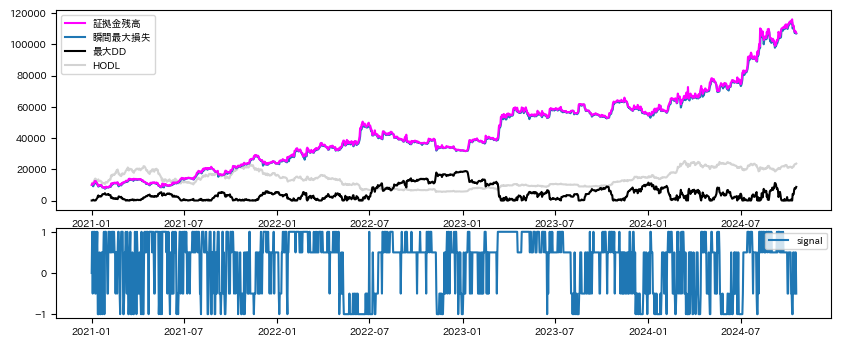

In [22]:
back_test = TakerBackTest(collateral=10000, leverage=1)
result = back_test.run(strategy)
plt.figure(figsize=(10, 4))
plt.subplot2grid((3, 1), (0, 0), rowspan=2)
plt.plot(result['balance'], label='証拠金残高', color='magenta', zorder=2)
plt.plot(result['balance'].shift(1) + result['max_loss'], label='瞬間最大損失', zorder=1)
plt.plot(result['max_dd'], label='最大DD', color='k')
plt.plot(10000 / result['binance_open'].iloc[0] * result['binance_close'], label='HODL', color='lightgray', zorder=0)
plt.legend()
plt.subplot2grid((3, 1), (2, 0))
plt.plot(result['signal'], label='signal')
plt.legend();

### 眺めてみる

- 2024年のバックテスト。

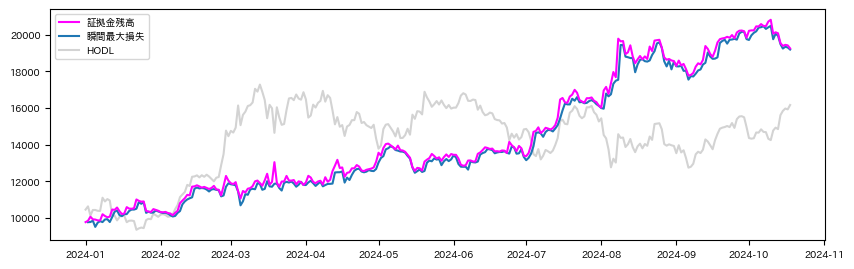

In [23]:
back_test = TakerBackTest(collateral=10000, leverage=1)
result = back_test.run(strategy['2024':'2024'])
plt.figure(figsize=(10, 3))
plt.plot(result['balance'], label='証拠金残高', color='magenta', zorder=2)
plt.plot(result['balance'].shift(1) + result['max_loss'], label='瞬間最大損失', zorder=1)
plt.plot(10000 / result['binance_open'].iloc[0] * result['binance_close'], label='HODL', color='lightgray', zorder=0)
plt.legend();

- レバレッジを上げてみる

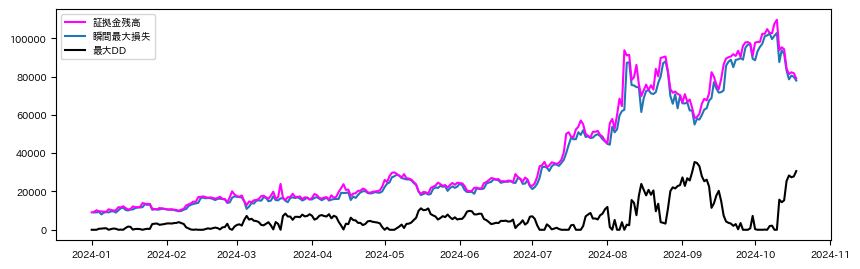

In [24]:
back_test = TakerBackTest(collateral=10000, leverage=4)
result = back_test.run(strategy['2024':'2024'])
plt.figure(figsize=(10, 3))
plt.plot(result['balance'], label='証拠金残高', color='magenta', zorder=2)
plt.plot(result['balance'].shift(1) + result['max_loss'], label='瞬間最大損失', zorder=1)
plt.plot(result['max_dd'], label='最大DD', color='k')
plt.legend();

### 以前の年

- 2021年のバックテスト結果を見てみる。
  - 年始からの高騰に乗れていない。
  - 後半から盛り返して、+150%程度の成績（HODLだと30000ドル→48000ドルなので、+60%）

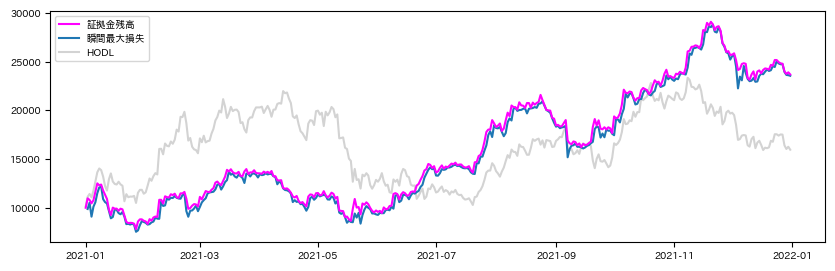

In [25]:
back_test = TakerBackTest(collateral=10000, leverage=1)
result = back_test.run(strategy['2021':'2021'])
plt.figure(figsize=(10, 3))
plt.plot(result['balance'], label='証拠金残高', color='magenta', zorder=2)
plt.plot(result['balance'].shift(1) + result['max_loss'], label='瞬間最大損失', zorder=1)
plt.plot(10000 / result['binance_open'].iloc[0] * result['binance_close'], label='HODL', color='lightgray', zorder=0)
plt.legend();

- 2022年のバックテスト結果を見てみる。
  - この年は年中下がりっぱなしであった。HODLだと48000ドル→16500ドルなので、-65%。
  - 6月の下落は取れたが、そこから半年にわたりドローダウン。HODLよりもよい成績だったとはいえ、辛い時期だった。

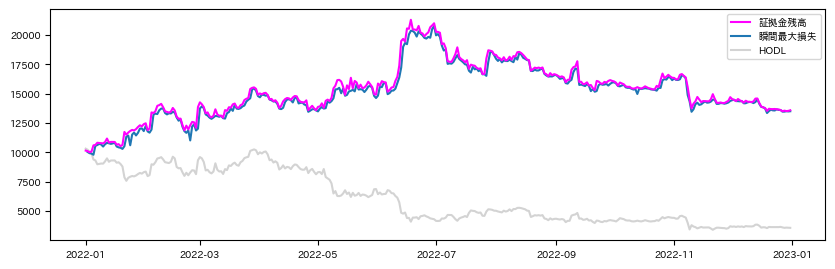

In [26]:
back_test = TakerBackTest(collateral=10000, leverage=1)
result = back_test.run(strategy['2022':'2022'])
plt.figure(figsize=(10, 3))
plt.plot(result['balance'], label='証拠金残高', color='magenta', zorder=2)
plt.plot(result['balance'].shift(1) + result['max_loss'], label='瞬間最大損失', zorder=1)
plt.plot(10000 / result['binance_open'].iloc[0] * result['binance_close'], label='HODL', color='lightgray', zorder=0)
plt.legend();

- 2023年のバックテスト結果を見てみる。
  - 10月からの上げを取れていない。この時期が一番辛そう。

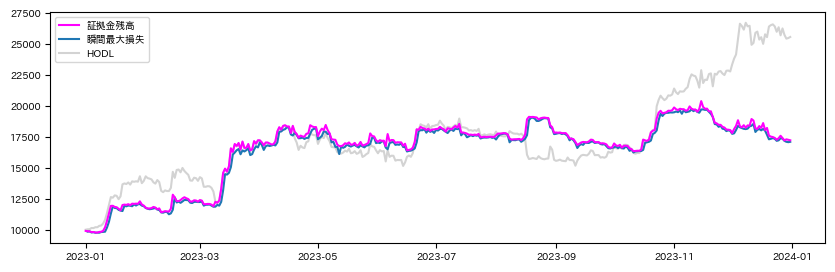

In [27]:
back_test = TakerBackTest(collateral=10000, leverage=1)
result = back_test.run(strategy['2023':'2023'])
plt.figure(figsize=(10, 3))
plt.plot(result['balance'], label='証拠金残高', color='magenta', zorder=2)
plt.plot(result['balance'].shift(1) + result['max_loss'], label='瞬間最大損失', zorder=1)
plt.plot(10000 / result['binance_open'].iloc[0] * result['binance_close'], label='HODL', color='lightgray', zorder=0)
plt.legend();

## 所感

- ビットコインの痛烈な下げを収益化できる可能性はある。
- 逆に、大きな上げを見逃す可能性もある。

- 運用のポイントとして、
  - 「ビットコインを保有している」とは思わないほうがよい。
  - 全く別の、「過去に渡っては」「数ヶ月単位で見ると」、右肩上がりの全く別アセットに投資している、という感覚が必要。
  - ビットコインの値動きと切り離してみたとき、投資対象としてここまでは有能に見える。

- 懸念事項として、
  - 「上げ相場でUSDTの需要が高まる」「下げ相場でUSDTから退避が起こる」という傾向に基づいている。
  - 以下のようなケースで、戦略がワークしなくなる可能性がある。
    - USDTがクリプト界隈での影響力を失う。他のステーブルコインの台頭など。
    - 各取引所の変化。例えばBitMEXやCoinbaseへの規制など。
    - 他の魅力的な市場の出現（例えば、直近の中国株バブルでUSDTが売られた）。
- 対応
  - 超長期に渡っては使えない、と念頭に置く。
  - レバレッジを抑えて、他の戦略と併用する。
  - 指標と値動きの相関をウォッチしておく。

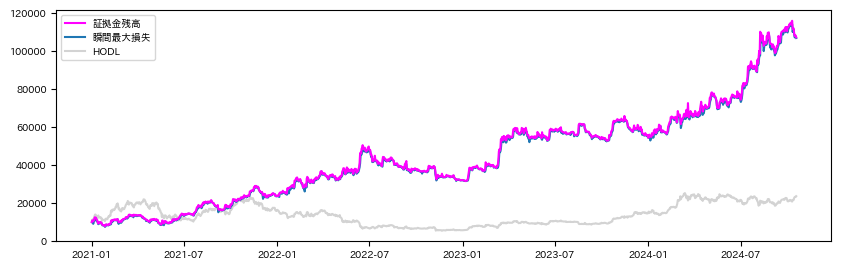

In [28]:
back_test = TakerBackTest(collateral=10000, leverage=1)
result = back_test.run(strategy)
plt.figure(figsize=(10, 3))
plt.plot(result['balance'], label='証拠金残高', color='magenta', zorder=2)
plt.plot(result['balance'].shift(1) + result['max_loss'], label='瞬間最大損失', zorder=1)
plt.plot(10000 / result['binance_open'].iloc[0] * result['binance_close'], label='HODL', color='lightgray', zorder=0)
plt.legend();

# コスト計測

- 想定しているコスト
  - テイカー手数料 5bp（=0.05%）
  - スリッページ 5bp
- ここでいうコストは、建てるポジションに対して何％、という計算の仕方。
  - 10000ドルのポジションを建てるときにコストが10bpということは、10ドル分コストを支払う、ということ。

- 今回は実際に運用しながら、以下をログにとってコスト計測します。想定以上のコストがかかっていた場合、原因を調査して対策します。
  - 発注までのタイムラグ
  - 発注の際の板の厚み
  - スリッページ
  - Close価格と約定価格のズレ
  - 指標（リアルタイムで計測する指標がバックテストとずれないか）
  - ポジション量（シミュレーションと整合が取れているか）

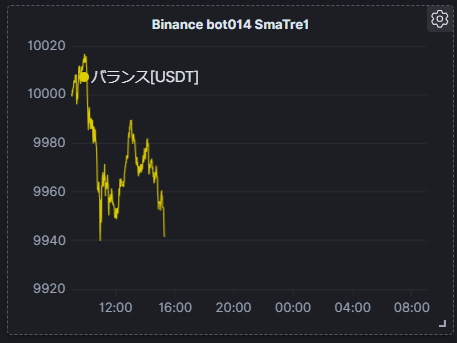

In [29]:
Image('./images/10_02.png')

# まとめと今後

- 今回はここまで。
- 通常、この先は以下のような流れになる
  - 少額でテスト稼働。
  - 実装上、あるいは実運用上の懸念点を洗い出す。
  - コスト見積もりが大幅に違わないかを確認する。
  - ある程度運用がこなれてきたら本番ロットにする。
- 定期的に以下を行っていきます。
  - 実運用での劣化度合いのチェック
  - 指標のブラッシュアップ
  - 執行のブラッシュアップ